In [12]:
from skimage.filters import gaussian 
from tensorflow.keras.applications import MobileNet
from skimage.color import rgb2hsv, hsv2rgb
import cv2 as cv
import matplotlib.pyplot as plt
import os
import glob
import pandas as pd
import numpy as np
import sys
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from sklearn.model_selection import train_test_split
import sys
import os
import glob

import datetime as dt

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import cv2 as cv

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf
import tensorflow.keras as keras


In [13]:
def get_data(sites, input):
    processing = input.loc[input['site'].isin(sites)]
    #print(processing.columns)
    #labels = processing.drop(['id','filepath','site','shape','height','width','N_channels','aspect_ratio','animal_label'], axis=1)
    processing_back = processing.copy()
    labels = processing.drop(['id','filepath','site'], axis=1)
    images = []

    for index, row in processing.iterrows():  
        image_path = row['filepath']
        #print(index)
        #print(image_path)
        image = cv.imread(os.path.join('../data/', image_path))
        image = cv.resize(image, (960, 540))
        images.append(image)
        #if (index == 0):
            #images = np.empty((processing.shape[0],) + image.shape, dtype=image.dtype)
        #images[index] = image
    #print("out of for")
    images = np.array(images)
    #print("made it here")
    return images, labels, processing_back

In [14]:
#get CMs for different epochs on hogs 
def print_augment_effect(aug_imgs, aug_labels, test_imgs, test_lbls, epochs):
    for epoch in epochs:
        hogs_model = tf.keras.models.load_model("finalweek_model.keras")
        show_confusion_matrix(hogs_model, test_imgs, test_lbls)
        for list_images in aug_imgs:
            hogs_model.fit(list_images, aug_labels, epochs=epoch, batch_size=32)
        show_confusion_matrix(hogs_model, test_imgs, test_lbls)
        del hogs_model

In [15]:
#show confusion matrix for unaugmented model
def show_confusion_matrix(model, test_images, true_labels):
   Y_pred_test = model.predict(test_images)
   Y_true_test = true_labels.to_numpy()
   a = np.argmax(Y_pred_test, axis=1)
   b = np.argmax(Y_true_test, axis=1)
   cm = confusion_matrix(a, b)
   plt.matshow(cm)
   plt.colorbar()
   plt.ylabel('True Label')
   plt.xlabel('Predicted Label')
   for (i, j), z in np.ndenumerate(cm):
      plt.text(j, i, format(z, 'd'), ha='center', va='center', fontsize=8, bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
   plt.show()

In [16]:
import pandas as pd
train_labels = pd.read_csv('../data/train_labels.csv')
train_features = pd.read_csv('../data/train_features.csv')

train_merged = pd.merge(train_labels, train_features, on='id')
train_merged_back = train_merged.copy()

unique_sites = train_merged['site'].unique()

temp_df = train_merged.groupby("site").sum()
temp_df.drop("id", axis=1, inplace=True)
temp_df.drop("filepath", axis=1, inplace=True)
#print(temp_df)
#print(temp_df.columns)
total_sightings = temp_df.iloc[:, 1:].sum(axis=1).tolist()
unique_sites = pd.DataFrame({"site": unique_sites, "total_sightings": total_sightings})
unique_sites = unique_sites.sort_values(by="total_sightings", ascending=False)
#print(unique_sites)

In [17]:
trainsites = ["S0110","S0083","S0047","S0022","S0134","S0125","S0025","S0144","S0159","S0157"]
train_img, train_lbl, full_train = get_data(trainsites, train_merged_back)
testsites = ["S0097","S0119","S0062","S0017","S0056","S0035","S0197","S0170","S0155","S0124"]
test_img, test_lbl, full_test = get_data(testsites, train_merged_back)

#"S0110","S0083","S0047","S0022","S0134","S0125","S0025","S0144","S0159","S0157","S0068",
#"S0014","S0173","S0051","S0188","S0030","S0161","S0077","S0073","S0108","S0069","S0088",
#"S0092","S0074","S0070","S0185","S0122","S0013","S0031","S0026","S0024","S0198","S0182",
#"S0097","S0119","S0062","S0017","S0056","S0035","S0197","S0170","S0155","S0124","S0147",
#"S0141","S0104","S0008","S0120","S0167","S0117","S0133","S0043","S0127","S0137","S0191",
#"S0172","S0036","S0020","S0063","S0044","S0015","S0160","S0059","S0102","S0003","S0085",
######"S0186","S0192","S0076","S0136","S0027","S0150","S0038","S0050","S0061","S0016","S0130",
######"S0009","S0164","S0096","S0045","S0001","S0081","S0105","S0129","S0021","S0093","S0089",
#"S0113","S0049","S0010","S0176","S0112","S0153","S0095","S0071","S0175","S0190","S0123",
#"S0053","S0138","S0146","S0101","S0028","S0131","S0178","S0171","S0098","S0032","S0156",
#"S0174","S0196","S0183","S0143","S0018","S0019","S0042","S0080","S0006","S0177","S0148",
#"S0106","S0075","S0004","S0007","S0005","S0169","S0107","S0002","S0029","S0180","S0121",
#"S0060","S0054","S0184","S0179","S0139","S0079","S0078","S0115","S0163","S0084","S0046",
#"S0094","S0023","S0149","S0193","S0158"

In [18]:
from tensorflow import keras
from tensorflow.keras.applications import EfficientNetV2B0

model_base = EfficientNetV2B0(include_top=False,
                              weights='imagenet',
                              input_shape=(540, 960, 3),
                            #   pooling="avg"  # include the ClobalAveragePooling2D layer  -- NOT done here, because otherwise the corresponding parameters would not be trainable
                              )

model_base.trainable = False

x = model_base.output
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(units=8,
                activation='softmax')(x)

model = keras.models.Model(inputs=model_base.input,outputs=outputs)

In [19]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [20]:
trainsites1 = ["S0110","S0083","S0047","S0022","S0134","S0125","S0025","S0144","S0159","S0157","S0068"]
trainsites2 = ["S0014","S0173","S0051","S0188","S0030","S0161","S0077","S0073","S0108","S0069","S0088"]
trainsites3 = ["S0092","S0074","S0070","S0185","S0122","S0013","S0031","S0026","S0024","S0198","S0182"]
trainsites4 = ["S0097","S0119","S0062","S0017","S0056","S0035","S0197","S0170","S0155","S0124","S0147"]
trainsites5 = ["S0141","S0104","S0008","S0120","S0167","S0117","S0133","S0043","S0127","S0137","S0191"]
trainsites6 = ["S0172","S0036","S0020","S0063","S0044","S0015","S0160","S0059","S0102","S0003","S0085"]

In [21]:
def fit_model(model, train_img, train_lbl):
    model.fit(train_img, train_lbl, epochs=5, batch_size=32)
    aug_img = []
    for image in train_img:
        aug_img.append(gaussian(image, sigma=1.5))
    aug_img = np.array(aug_img)
    model.fit(aug_img, train_lbl, epochs=5, batch_size=32)
    aug_img = []
    for image in train_img:
        flipped_image = np.flip(image, axis=1)
        aug_img.append(flipped_image)
    aug_img = np.array(aug_img)
    model.fit(aug_img, train_lbl, epochs=5, batch_size=32)
    aug_img = []
    noise_red = np.random.randint(10, 50, size=image.shape[:2])
    noise_green = np.random.randint(-20, -10, size=image.shape[:2])
    noise_blue = np.random.randint(10, 50, size=image.shape[:2])
    for image in train_img:
        img_bak = image.copy()
        img_bak[:,:,0] += noise_red.astype(np.uint8)
        img_bak[:,:,1] += noise_green.astype(np.uint8)
        img_bak[:,:,2] += noise_blue.astype(np.uint8)
        img_bak = np.clip(img_bak, 0, 255)
        aug_img.append(img_bak)
    aug_img = np.array(aug_img)
    model.fit(aug_img, train_lbl, epochs=5, batch_size=32)



In [22]:
#train_img, train_lbl, full_train = get_data(trainsites1, train_merged_back)
train_list = full_train
#fit_model(model, train_img, train_lbl)
#train_img, train_lbl, full_train = get_data(trainsites2, train_merged_back)
##train_list = pd.concat([train_list, full_train])
#model.save("threshhol1.keras")
model = tf.keras.models.load_model("threshhol1.keras")
fit_model(model, train_img, train_lbl)
train_img, train_lbl, full_train = get_data(trainsites3, train_merged_back)
train_list = pd.concat([train_list, full_train])
model.save("threshhol2.keras")
fit_model(model, train_img, train_lbl)
train_img, train_lbl, full_train = get_data(trainsites4, train_merged_back)
train_list = pd.concat([train_list, full_train])
model.save("threshhol3.keras")
fit_model(model, train_img, train_lbl)
train_list = pd.concat([train_list, full_train])
model.save("threshhol4.keras")
print(train_list.head())
print(train_list.shape)

Epoch 1/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 126s 4s/step - accuracy: 0.8000 - loss: 0.5423
Epoch 2/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 135s 4s/step - accuracy: 0.8405 - loss: 0.4941
Epoch 3/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 139s 5s/step - accuracy: 0.8166 - loss: 0.5092
Epoch 4/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 142s 5s/step - accuracy: 0.8216 - loss: 0.5185
Epoch 5/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 129s 4s/step - accuracy: 0.8220 - loss: 0.5199
Epoch 1/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 117s 4s/step - accuracy: 0.2307 - loss: 2.0746
Epoch 2/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 122s 4s/step - accuracy: 0.2135 - loss: 1.9363
Epoch 3/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 121s 4s/step - accuracy: 0.2172 - loss: 1.9327
Epoch 4/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 122s 4s/step - accuracy: 0.2663 - loss: 1.8898
Epoch 5/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 122s 4s/step - accuracy: 0.2746 - loss: 1.8818
Epoch 1/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 116s 4s/step - accuracy: 0.8155 - loss: 0.5381
Epoch 2/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 116s 4s/step - accuracy: 0.8257 - loss:

In [23]:

testsites1 = ["S0186","S0192","S0076","S0136","S0027","S0150","S0038","S0050","S0061","S0016","S0130"]
test_img, test_lbl, full_test = get_data(testsites1, train_merged_back)

In [24]:
model.save("finalweek_model_three.keras")

43/43 ━━━━━━━━━━━━━━━━━━━━ 197s 5s/step


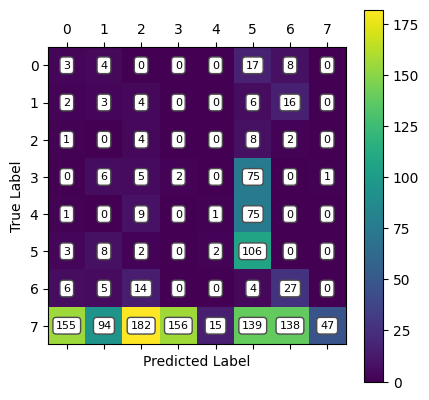

In [25]:
show_confusion_matrix(model, test_img, test_lbl)

In [26]:
#save inside of label_hogs all the rows from train_lbl where train_lbl["hog"] == 1
full_train = train_list
#print(full_train.head())
list_hogs = full_train[full_train["hog"] == 1]
#print(list_hogs.head())
hogs_labels = list_hogs.drop(['id','filepath','site'], axis=1)

images = []

for index, row in list_hogs.iterrows():  
    image_path = row['filepath']
    image = cv.imread(os.path.join('../data/', image_path))
    image = cv.resize(image, (960, 540))
    images.append(image)

hog_images = np.array(images)

In [27]:
flipped_hogs = []
for image in hog_images:
    flipped_image = np.flip(image, axis=1)
    flipped_hogs.append(flipped_image)
flipped_hogs = np.array(flipped_hogs)



In [28]:

gaussian_hogs = []
for image in hog_images:
    gaussian_hogs.append(gaussian(image, sigma=1.5))
gaussian_hogs = np.array(gaussian_hogs)


In [29]:
jittered_hogs = []
noise_red = np.random.randint(10, 50, size=image.shape[:2])
noise_green = np.random.randint(-20, -10, size=image.shape[:2])
noise_blue = np.random.randint(10, 50, size=image.shape[:2])
for image in hog_images:
    img_bak = image.copy()
    img_bak[:,:,0] += noise_red.astype(np.uint8)
    img_bak[:,:,1] += noise_green.astype(np.uint8)
    img_bak[:,:,2] += noise_blue.astype(np.uint8)
    img_bak = np.clip(img_bak, 0, 255)
    jittered_hogs.append(img_bak)
jittered_hogs = np.array(jittered_hogs)

In [30]:
list_augs = []
list_augs.append(flipped_hogs)
list_augs.append(gaussian_hogs)
list_augs.append(jittered_hogs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 228s 5s/step


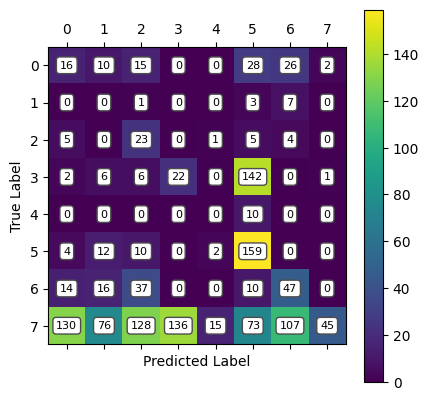

7/7 ━━━━━━━━━━━━━━━━━━━━ 38s 5s/step - accuracy: 0.6655 - loss: 1.6127
7/7 ━━━━━━━━━━━━━━━━━━━━ 35s 5s/step - accuracy: 1.0000 - loss: 0.7046
7/7 ━━━━━━━━━━━━━━━━━━━━ 33s 5s/step - accuracy: 0.8965 - loss: 0.4101
43/43 ━━━━━━━━━━━━━━━━━━━━ 223s 5s/step


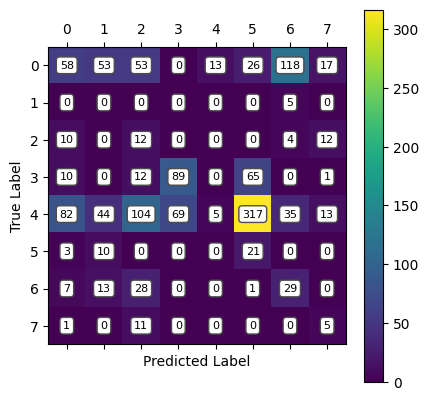

43/43 ━━━━━━━━━━━━━━━━━━━━ 177s 4s/step


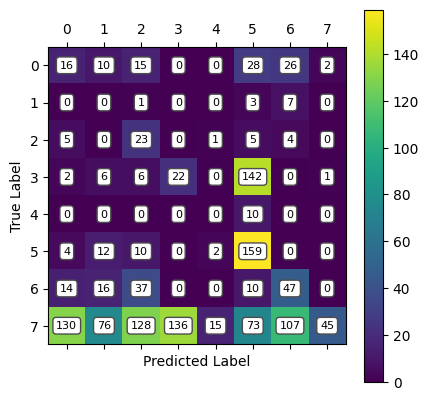

Epoch 1/3
7/7 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.5808 - loss: 1.7676
Epoch 2/3
7/7 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.8355 - loss: 0.5247
Epoch 3/3
7/7 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.9761 - loss: 0.1079
Epoch 1/3
7/7 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 1.0000 - loss: 0.5137
Epoch 2/3
7/7 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 1.0000 - loss: 0.0615
Epoch 3/3
7/7 ━━━━━━━━━━━━━━━━━━━━ 26s 4s/step - accuracy: 1.0000 - loss: 0.0082
Epoch 1/3
7/7 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.9981 - loss: 0.0430
Epoch 2/3
7/7 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.9950 - loss: 0.0434
Epoch 3/3
7/7 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 1.0000 - loss: 0.0241
43/43 ━━━━━━━━━━━━━━━━━━━━ 175s 4s/step


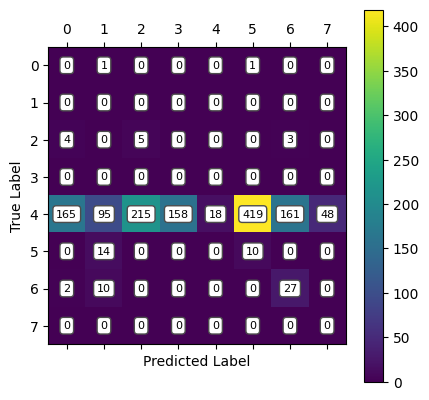

43/43 ━━━━━━━━━━━━━━━━━━━━ 177s 4s/step


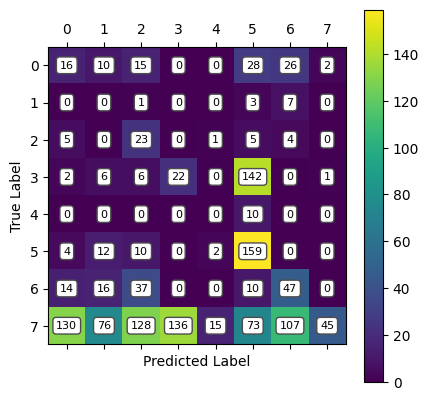

Epoch 1/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.6287 - loss: 1.7073
Epoch 2/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.8214 - loss: 0.5753
Epoch 3/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.9890 - loss: 0.0938
Epoch 4/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 1.0000 - loss: 0.0313
Epoch 5/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.9950 - loss: 0.0268
Epoch 1/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 1.0000 - loss: 0.4258
Epoch 2/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 1.0000 - loss: 0.0601
Epoch 3/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 26s 4s/step - accuracy: 1.0000 - loss: 0.0095
Epoch 4/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 26s 4s/step - accuracy: 1.0000 - loss: 0.0036
Epoch 5/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 26s 4s/step - accuracy: 1.0000 - loss: 0.0022
Epoch 1/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 1.0000 - loss: 0.0306
Epoch 2/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 1.0000 - loss: 0.0226
Epoch 3/5
7/7 ━━━━━━━━━━━━━━

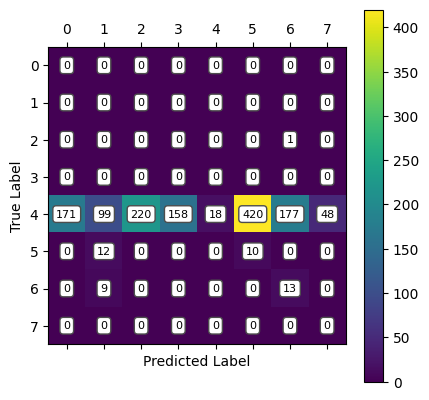

In [31]:
print_augment_effect(list_augs, hogs_labels, test_img, test_lbl, [1, 3, 5])